In [ ]:
# load necessary libraries
library(tidyverse)
library(rlang)

In [169]:
# read SHAP and LIME data for "buck" and "laws", subjects 2 and 3
shap_buck2 <- read.csv("shap_buck_subj2.csv")
shap_buck3 <- read.csv("shap_buck_subj3.csv")

shap_laws2 <- read.csv("shap_laws_subj2.csv")
shap_laws3 <- read.csv("shap_laws_subj3.csv")

lime_buck2 <- read.csv("lime_buck_subj2.csv")
lime_buck3 <- read.csv("lime_buck_subj3.csv")

lime_laws2 <- read.csv("lime_laws_subj2.csv")
lime_laws3 <- read.csv("lime_laws_subj3.csv")

In [171]:
# extract story chunk and word info
buck_words <- shap_buck2 %>% select(chunk_id, word_id, word)
laws_words <- shap_laws2 %>% select(chunk_id, word_id, word)

In [411]:
#' Average voxel values for each row and optionally retain word info
#' @param df A dataframe with voxel columns
#' @param words Logical; include word columns if TRUE
avg_over_voxels <- function(df, words=TRUE) {
    df <- df %>% mutate(vmean = rowMeans(select(., starts_with("v_")), na.rm = TRUE))
    if (words) {
        df %>% select(chunk_id, word_id, word, vmean)
    } else {
        df %>% filter(word_id == 1) %>% select(chunk_id, vmean)
    }
}

#' Merge a list of dataframes on chunk_id and rename/rank columns
#' @param df_list List of dataframes to merge
#' @param col_names New names for vmean columns
#' @param old Original column name to rename (default "vmean")
merge_on_story <- function(df_list, col_names, old="vmean") {
    n = length(df_list)
    df = df_list[[1]]
    
    df <- df %>%
        rename(!!col_names[1] := !!sym(old)) %>%
        mutate(!!paste(col_names[1], "rank", sep="_") := rank(!!sym(col_names[1])))

    for (i in 2:n) {
        dfi = df_list[[i]]
        dfi <- dfi %>%
            rename(!!col_names[i] := !!sym(old)) %>%
            mutate(!!paste(col_names[i], "rank", sep="_") := rank(!!sym(col_names[i])))
        df <- df %>% inner_join(dfi, by = join_by(chunk_id))
    }
    return(df)   
}

#' Compute various average and rank combinations across SHAP/LIME and subjects
#' @param df A dataframe with SHAP and LIME columns and ranks
avg_over_ranks <- function(df) {
    df <- df %>%
        mutate(shap_avg = rowMeans(select(., c(shap_2, shap_3)), na.rm = TRUE),
               lime_avg = rowMeans(select(., c(lime_2, lime_3)), na.rm = TRUE),
               shap_avg_rank = rank(shap_avg),
               lime_avg_rank = rank(lime_avg),
               rank_avg_shap = rowMeans(select(., c(shap_2_rank, shap_3_rank)), na.rm = TRUE),
               rank_avg_lime = rowMeans(select(., c(lime_2_rank, lime_3_rank)), na.rm = TRUE),
               rank_avg_2 = rowMeans(select(., c(shap_2_rank, lime_2_rank)), na.rm = TRUE),
               rank_avg_3 = rowMeans(select(., c(shap_3_rank, lime_3_rank)), na.rm = TRUE),
               rank_avg = rowMeans(select(., c(shap_2_rank, shap_3_rank, lime_2_rank, lime_3_rank)), na.rm = TRUE))
    return(df)
}

#' Compute rank across voxel columns for each chunk
#' @param df A dataframe with voxel columns (v_*)
rank_per_voxel <- function(df) {
    df_story <- df %>% select(chunk_id, word_id, word)
    df_rank <- df %>%
      filter(word_id == 1) %>%
      select(-word_id, -word) %>%
      mutate(across(starts_with("v_"), ~ rank(.), .names = "rank_{.col}")) %>%
      rename_with(~ sub("rank_v_", "rank_", .), starts_with("rank_v_"))
    df_story %>% inner_join(df_rank, by = join_by(chunk_id))
}

#' Pivot voxel rank columns into long format for plotting
#' @param df Dataframe with ranked voxel columns
#' @param colname Base name for the score type (e.g., "shap" or "lime")
voxel_longer <- function(df, colname="value") {
    df %>%
        filter(word_id == 1) %>%
        select(-starts_with("v_"), -word_id, -word) %>%
        pivot_longer(cols = starts_with("rank_"),
                     names_to = "v_i",
                     names_prefix = "rank_",
                     values_to = paste(colname, "rank", sep="_")) %>%
        mutate(v_i = as.numeric(v_i))
}

#' Merge SHAP and LIME voxel rankings into one long-format dataframe
#' @param shap2, shap3, lime2, lime3 Dataframes of voxel-level scores
voxel_merge <- function(shap2, shap3, lime2, lime3) {
    df2 <- shap2 %>%
        inner_join(lime2, by=join_by(chunk_id, v_i)) %>%
        mutate(subject_id = "2")
    
    df3 <- shap3 %>%
        inner_join(lime3, by=join_by(chunk_id, v_i)) %>%
        mutate(subject_id = "3")

    df <- rbind(df2, df3) %>%
        pivot_longer(cols = ends_with("_rank"),
                     names_to = "score",
                     names_pattern = "^(.*)_rank$",
                     values_to = "rank")
    df
}

In [318]:
# prepare data lists and calculate averaged voxel values
buck_list <- list(shap_buck2, shap_buck3, lime_buck2, lime_buck3)
laws_list <- list(shap_laws2, shap_laws3, lime_laws2, lime_laws3)

buck_avg_list <- lapply(buck_list, avg_over_voxels, FALSE)
laws_avg_list <- lapply(laws_list, avg_over_voxels, FALSE)

col_names <- c("shap_2", "shap_3", "lime_2", "lime_3")

# merge and rank SHAP/LIME values by chunk for "buck" and "laws"
buck_all <- merge_on_story(buck_avg_list, col_names) %>%
    avg_over_ranks() %>%
    right_join(buck_words, by = join_by(chunk_id))

laws_all <- merge_on_story(laws_avg_list, col_names) %>%
    avg_over_ranks() %>%
    right_join(laws_words, by = join_by(chunk_id))

# preview merged data
head(buck_all, 5)
head(laws_all, 5)

In [174]:
# save results to CSV
write.csv(buck_all, "buck.csv", row.names=FALSE)
write.csv(laws_all, "laws.csv", row.names=FALSE)

In [412]:
# rank voxel values for each chunk
shap_buck2_voxels <- rank_per_voxel(shap_buck2)
shap_buck3_voxels <- rank_per_voxel(shap_buck3)

lime_buck2_voxels <- rank_per_voxel(lime_buck2)
lime_buck3_voxels <- rank_per_voxel(lime_buck3)

shap_laws2_voxels <- rank_per_voxel(shap_laws2)
shap_laws3_voxels <- rank_per_voxel(shap_laws3)

lime_laws2_voxels <- rank_per_voxel(lime_laws2)
lime_laws3_voxels <- rank_per_voxel(lime_laws3)

In [413]:
# convert voxel-wise SHAP/LIME scores to long format
shap_buck2_voxels_longer <- voxel_longer(shap_buck2_voxels, "shap")
shap_buck3_voxels_longer <- voxel_longer(shap_buck3_voxels, "shap")

lime_buck2_voxels_longer <- voxel_longer(lime_buck2_voxels, "lime")
lime_buck3_voxels_longer <- voxel_longer(lime_buck3_voxels, "lime")

shap_laws2_voxels_longer <- voxel_longer(shap_laws2_voxels, "shap")
shap_laws3_voxels_longer <- voxel_longer(shap_laws3_voxels, "shap")

lime_laws2_voxels_longer <- voxel_longer(lime_laws2_voxels, "lime")
lime_laws3_voxels_longer <- voxel_longer(lime_laws3_voxels, "lime")

In [414]:
# merge SHAP and LIME long-format voxel scores
buck_voxel <- voxel_merge(shap_buck2_voxels_longer,
                          shap_buck3_voxels_longer,
                          lime_buck2_voxels_longer,
                          lime_buck3_voxels_longer)

laws_voxel <- voxel_merge(shap_laws2_voxels_longer,
                          shap_laws3_voxels_longer,
                          lime_laws2_voxels_longer,
                          lime_laws3_voxels_longer)

# inspect voxel data
head(buck_voxel)
head(laws_voxel)

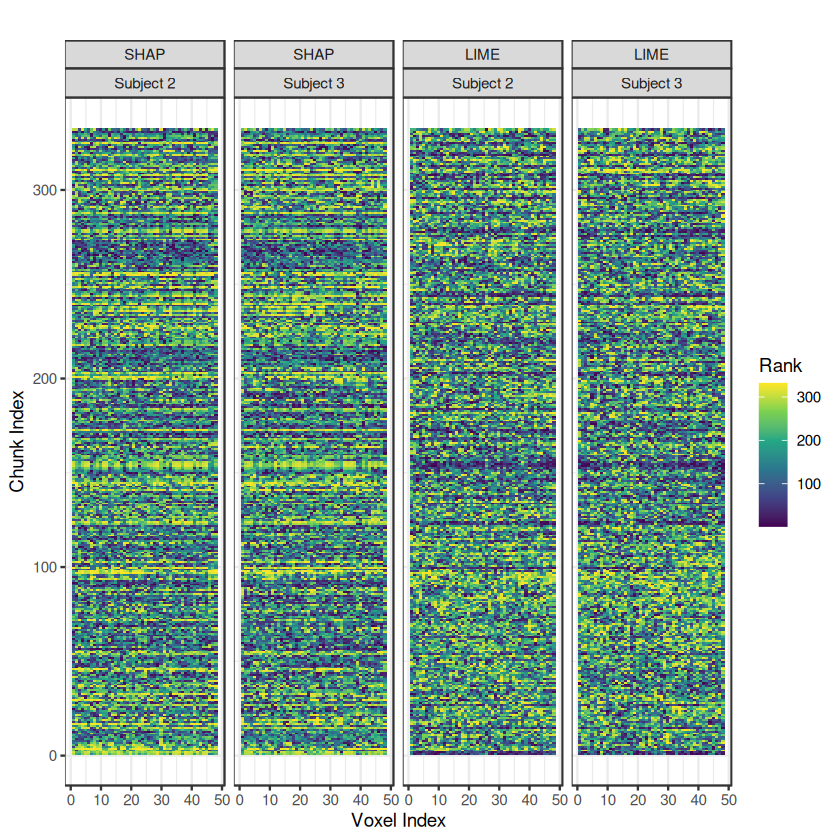

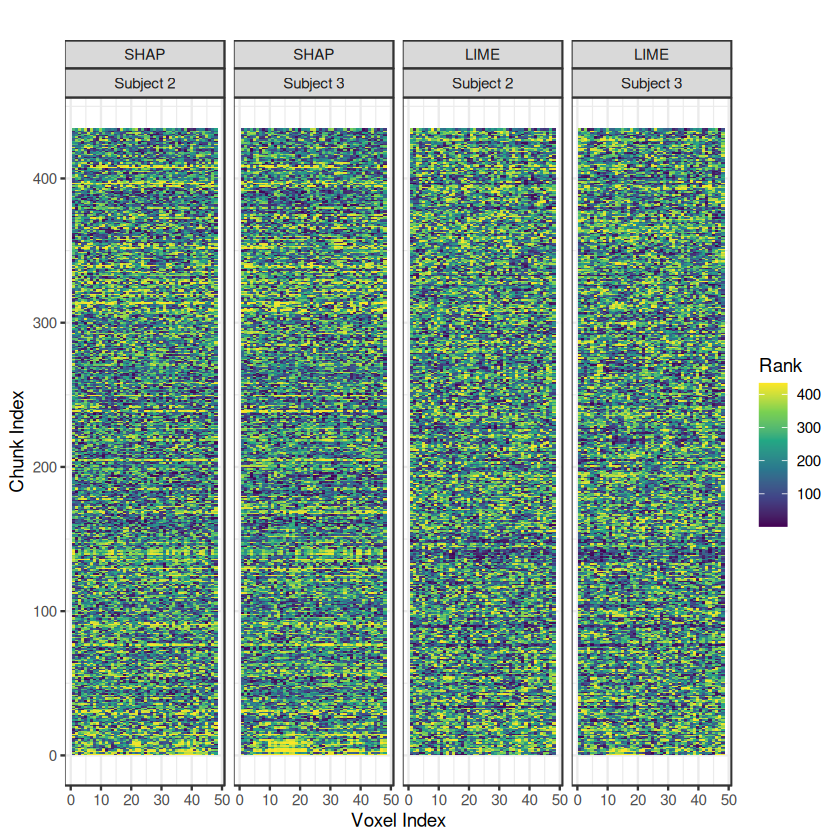

In [538]:
# create heatmap of voxel importance ranks for buck and laws dataset
heatmap_buck <- buck_voxel %>%
    mutate(score = factor(score, levels=c("shap", "lime"), labels=c("SHAP", "LIME")),
           subject_id = factor(subject_id, levels=c("2", "3"), labels=c("Subject 2", "Subject 3"))) %>%
    ggplot(aes(x = v_i, y = chunk_id, fill = rank)) +
    geom_tile() +
    facet_wrap(score~subject_id, ncol=4) +
    scale_fill_viridis_c() +
    labs(title="",
         x = "Voxel Index",
         y = "Chunk Index",
         fill = "Rank") +
    theme_bw()

heatmap_laws <- laws_voxel %>%
    mutate(score = factor(score, levels=c("shap", "lime"), labels=c("SHAP", "LIME")),
           subject_id = factor(subject_id, levels=c("2", "3"), labels=c("Subject 2", "Subject 3"))) %>%
    ggplot(aes(x = v_i, y = chunk_id, fill = rank)) +
    geom_tile() +
    facet_wrap(score~subject_id, ncol=4) +
    scale_fill_viridis_c() +
    labs(title="",
         x = "Voxel Index",
         y = "Chunk Index",
         fill = "Rank") +
    theme_bw()

heatmap_buck
heatmap_laws

In [534]:
# save heatmaps
ggsave("heatmap_buck.png", heatmap_buck, width=6, height=9)
ggsave("heatmap_laws.png", heatmap_laws, width=6, height=9)

In [527]:
# define custom color palette
SHAP_LIGHT <- "tomato2"
SHAP_DARK <- "red4"
LIME_LIGHT <- "skyblue3"
LIME_DARK <- "navy"
GRAY_LIGHT <- "gray60"
GRAY_DARK <- "gray30"

`summarise()` has grouped output by 'chunk_id', 'subject_id'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'chunk_id', 'subject_id'. You can override
using the `.groups` argument.


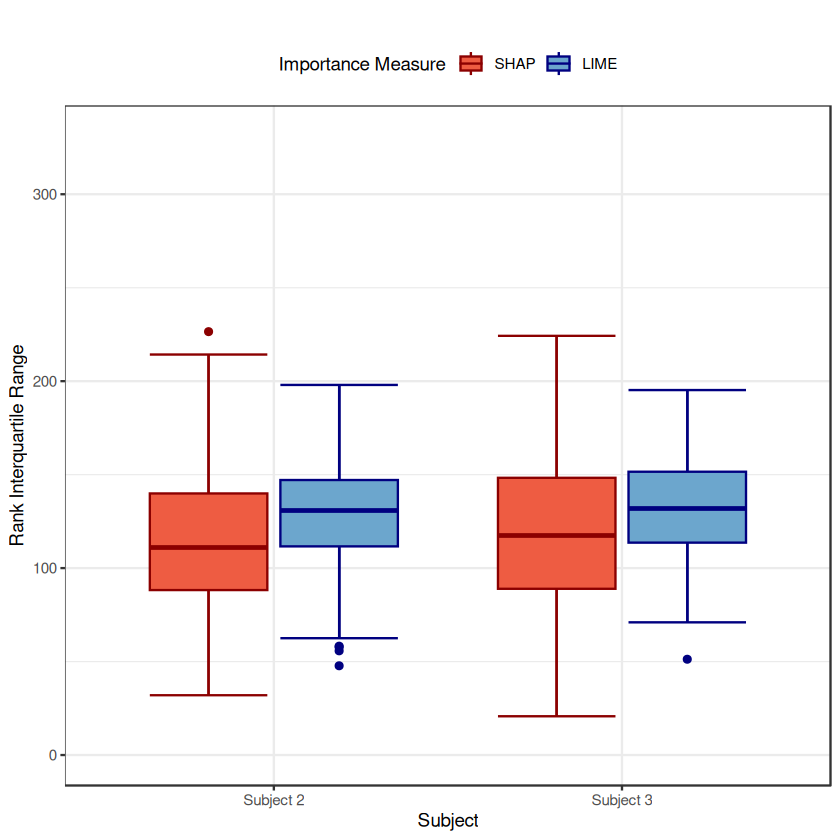

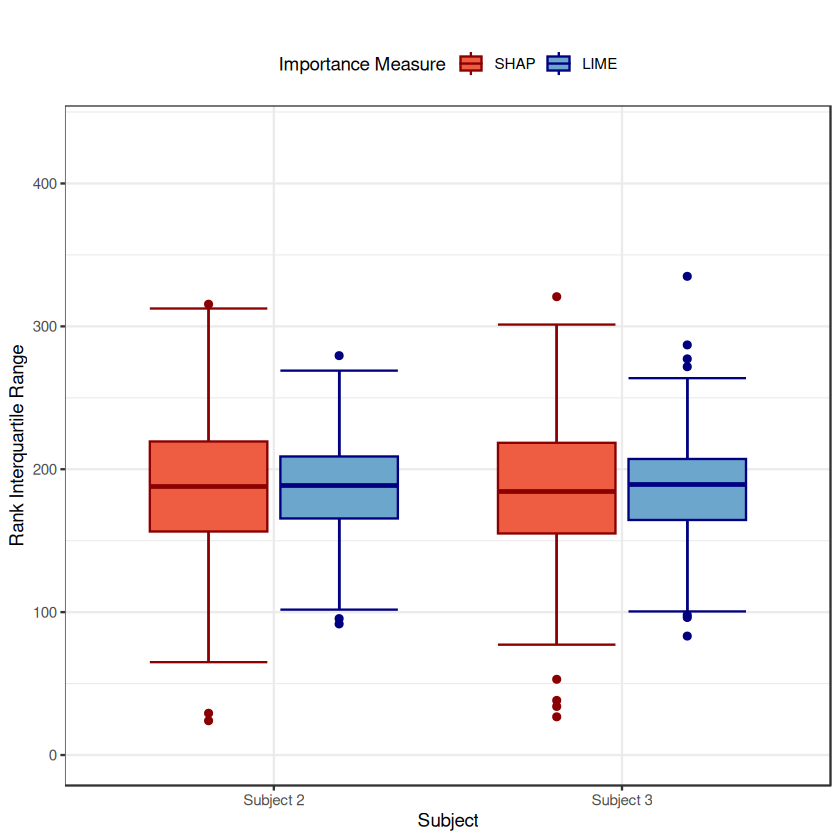

In [540]:
# Create boxplot for buck and laws (note: different y-axis scaling)
# showing variability in voxel rank (IQR) per chunk
boxplot_buck <- buck_voxel %>%
    mutate(score = factor(score, levels=c("shap", "lime"), labels=c("SHAP", "LIME")),
           subject_id = factor(subject_id, levels=c("2", "3"), labels=c("Subject 2", "Subject 3"))) %>%
    group_by(chunk_id, subject_id, score) %>%
    summarize(rank_avg = mean(rank),
              rank_std = sd(rank),
              rank_range = max(rank) - min(rank),
              rank_iqr = IQR(rank)) %>%
    ggplot(aes(y=rank_iqr, x=subject_id, fill=score, color=score)) +
    stat_boxplot(geom ='errorbar') + 
    geom_boxplot() +
    scale_fill_manual(values=c("SHAP"=SHAP_LIGHT, "LIME"=LIME_LIGHT)) +
    scale_color_manual(values=c("SHAP"=SHAP_DARK, "LIME"=LIME_DARK)) +
    scale_y_continuous(limits=c(0, 331)) +
    labs(title="",
         x="Subject",
         y="Rank Interquartile Range",
         fill="Importance Measure",
         color="Importance Measure") +
    theme_bw() + theme(legend.position="top")

boxplot_laws <- laws_voxel %>%
    mutate(score = factor(score, levels=c("shap", "lime"), labels=c("SHAP", "LIME")),
           subject_id = factor(subject_id, levels=c("2", "3"), labels=c("Subject 2", "Subject 3"))) %>%
    group_by(chunk_id, subject_id, score) %>%
    summarize(rank_avg = mean(rank),
              rank_std = sd(rank),
              rank_range = max(rank) - min(rank),
              rank_iqr = IQR(rank)) %>%
    ggplot(aes(y=rank_iqr, x=subject_id, fill=score, color=score)) +
    stat_boxplot(geom ='errorbar') + 
    geom_boxplot() +
    scale_fill_manual(values=c("SHAP"=SHAP_LIGHT, "LIME"=LIME_LIGHT)) +
    scale_color_manual(values=c("SHAP"=SHAP_DARK, "LIME"=LIME_DARK)) +
    scale_y_continuous(limits=c(0, 433)) +
    labs(title="",
         x="Subject",
         y="Rank Interquartile Range",
         fill="Importance Measure",
         color="Importance Measure") +
    theme_bw() + theme(legend.position="top")

boxplot_buck
boxplot_laws

In [541]:
# save boxplots
ggsave("boxplot_buck.png", boxplot_buck, width = 6, height = 9)
ggsave("boxplot_laws.png", boxplot_laws, width = 6, height = 9)

In [529]:
# create scatterplots for buck and laws
# comparing raw and ranked importance across subjects
scatter_buck_shap_raw <- buck_all %>%
    filter(word_id == 1) %>%
    ggplot(aes(x=shap_2, y=shap_3)) +
    geom_point(alpha=0.7, color=SHAP_LIGHT) +
    geom_smooth(method='lm', se=FALSE, linetype=2, color=SHAP_DARK) +
    labs(x="Raw SHAP, Subject 2",
         y="Raw SHAP, Subject 3") +
    theme_bw()


scatter_buck_shap_rank <- buck_all %>%
    filter(word_id == 1) %>%
    ggplot(aes(x=shap_2_rank, y=shap_3_rank)) +
    geom_point(alpha=0.7, color=SHAP_LIGHT) +
    geom_smooth(method='lm', se=FALSE, linetype=2, color=SHAP_DARK) +
    labs(x="SHAP Rank, Subject 2",
         y="SHAP Rank, Subject 3") +
    theme_bw()

scatter_buck_lime_raw <- buck_all %>%
    filter(word_id == 1) %>%
    ggplot(aes(x=lime_2, y=lime_3)) +
    geom_point(alpha=0.7, color=LIME_LIGHT) +
    geom_smooth(method='lm', se=FALSE, linetype=2, color=LIME_DARK) +
    labs(x="Raw LIME, Subject 2",
         y="Raw LIME, Subject 3") +
    theme_bw()


scatter_buck_lime_rank <- buck_all %>%
    filter(word_id == 1) %>%
    ggplot(aes(x=lime_2_rank, y=lime_3_rank)) +
    geom_point(alpha=0.7, color=LIME_LIGHT) +
    geom_smooth(method='lm', se=FALSE, linetype=2, color=LIME_DARK) +
    labs(x="LIME Rank, Subject 2",
         y="LIME Rank, Subject 3") +
    theme_bw()

scatter_buck_rank <- buck_all %>%
    filter(word_id == 1) %>%
    ggplot(aes(x=rank_avg_shap, y=rank_avg_lime)) +
    geom_point(alpha=0.7, color=GRAY_LIGHT) +
    geom_smooth(method='lm', se=FALSE, linetype=2, color=GRAY_DARK) +
    labs(x="Avg. SHAP Rank",
         y="Avg. LIME Rank") +
    theme_bw()


scatter_laws_shap_raw <- laws_all %>%
    filter(word_id == 1) %>%
    ggplot(aes(x=shap_2, y=shap_3)) +
    geom_point(alpha=0.7, color=SHAP_LIGHT) +
    geom_smooth(method='lm', se=FALSE, linetype=2, color=SHAP_DARK) +
    labs(x="Raw SHAP, Subject 2",
         y="Raw SHAP, Subject 3") +
    theme_bw()


scatter_laws_shap_rank <- laws_all %>%
    filter(word_id == 1) %>%
    ggplot(aes(x=shap_2_rank, y=shap_3_rank)) +
    geom_point(alpha=0.7, color=SHAP_LIGHT) +
    geom_smooth(method='lm', se=FALSE, linetype=2, color=SHAP_DARK) +
    labs(x="SHAP Rank, Subject 2",
         y="SHAP Rank, Subject 3") +
    theme_bw()

scatter_laws_lime_raw <- laws_all %>%
    filter(word_id == 1) %>%
    ggplot(aes(x=lime_2, y=lime_3)) +
    geom_point(alpha=0.7, color=LIME_LIGHT) +
    geom_smooth(method='lm', se=FALSE, linetype=2, color=LIME_DARK) +
    labs(x="Raw LIME, Subject 2",
         y="Raw LIME, Subject 3") +
    theme_bw()


scatter_laws_lime_rank <- laws_all %>%
    filter(word_id == 1) %>%
    ggplot(aes(x=lime_2_rank, y=lime_3_rank)) +
    geom_point(alpha=0.7, color=LIME_LIGHT) +
    geom_smooth(method='lm', se=FALSE, linetype=2, color=LIME_DARK) +
    labs(x="LIME Rank, Subject 2",
         y="LIME Rank, Subject 3") +
    theme_bw()

scatter_laws_rank <- laws_all %>%
    filter(word_id == 1) %>%
    ggplot(aes(x=rank_avg_shap, y=rank_avg_lime)) +
    geom_point(alpha=0.7, color=GRAY_LIGHT) +
    geom_smooth(method='lm', se=FALSE, linetype=2, color=GRAY_DARK) +
    labs(x="Avg. SHAP Rank",
         y="Avg. LIME Rank") +
    theme_bw()

In [530]:
# save scatterplots
ggsave("scatter_buck_shap_raw.png", scatter_buck_shap_raw, width = 5, height = 5)
ggsave("scatter_buck_shap_rank.png", scatter_buck_shap_rank, width = 5, height = 5)
ggsave("scatter_buck_lime_raw.png", scatter_buck_lime_raw, width = 5, height = 5)
ggsave("scatter_buck_lime_rank.png", scatter_buck_lime_rank, width = 5, height = 5)
ggsave("scatter_buck_rank.png", scatter_buck_rank, width = 5, height = 5)

ggsave("scatter_laws_shap_raw.png", scatter_laws_shap_raw, width = 5, height = 5)
ggsave("scatter_laws_shap_rank.png", scatter_laws_shap_rank, width = 5, height = 5)
ggsave("scatter_laws_lime_raw.png", scatter_laws_lime_raw, width = 5, height = 5)
ggsave("scatter_laws_lime_rank.png", scatter_laws_lime_rank, width = 5, height = 5)
ggsave("scatter_laws_rank.png", scatter_laws_rank, width = 5, height = 5)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


In [ ]:
# style and print words from buck (threshold = top 25%)
buck_all <- buck_all %>%
    mutate(ind_shap = ifelse(shap_avg_rank/max(shap_avg_rank) >= 0.75, 1, 0),
           ind_lime = ifelse(lime_avg_rank/max(lime_avg_rank) >= 0.75, 1, 0),
           sty_prefix = case_when(
               ind_shap + ind_lime == 2 ~ r"(\textbf{)",
               ind_shap == 1 ~ r"(\textcolor{Maroon}{)",
               ind_lime == 1 ~ r"(\textcolor{RoyalBlue}{)",
               .default = ""),
          sty_suffix = ifelse(sty_prefix == "", "", "}"),
          text = paste(sty_prefix, word, sty_suffix, sep=""))

# extract non-empty words and print as a latex-formatted string
styled_text <- buck_all %>% filter(word != "") %>% pull(text)
cat(paste(styled_text, collapse=" "))

In [ ]:
# style and print words from laws (threshold = top 25%)
laws_all <- laws_all %>%
    mutate(ind_shap = ifelse(shap_avg_rank/max(shap_avg_rank) >= 0.75, 1, 0),
           ind_lime = ifelse(lime_avg_rank/max(lime_avg_rank) >= 0.75, 1, 0),
           sty_prefix = case_when(
               ind_shap + ind_lime == 2 ~ r"(\textbf{)",
               ind_shap == 1 ~ r"(\textcolor{Maroon}{)",
               ind_lime == 1 ~ r"(\textcolor{RoyalBlue}{)",
               .default = ""),
          sty_suffix = ifelse(sty_prefix == "", "", "}"),
          text = paste(sty_prefix, word, sty_suffix, sep=""))

# extract non-empty words and print as a latex-formatted string
styled_text <- laws_all %>% filter(word != "") %>% pull(text)
cat(paste(styled_text, collapse=" "))